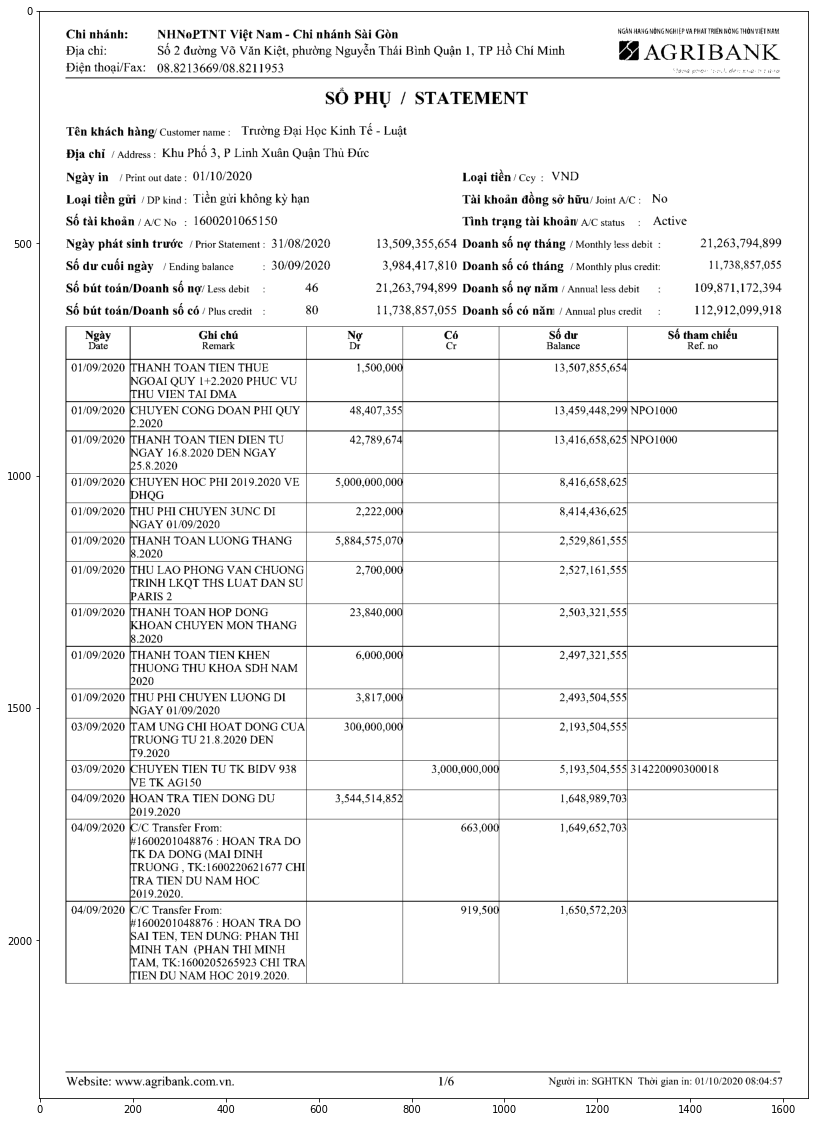

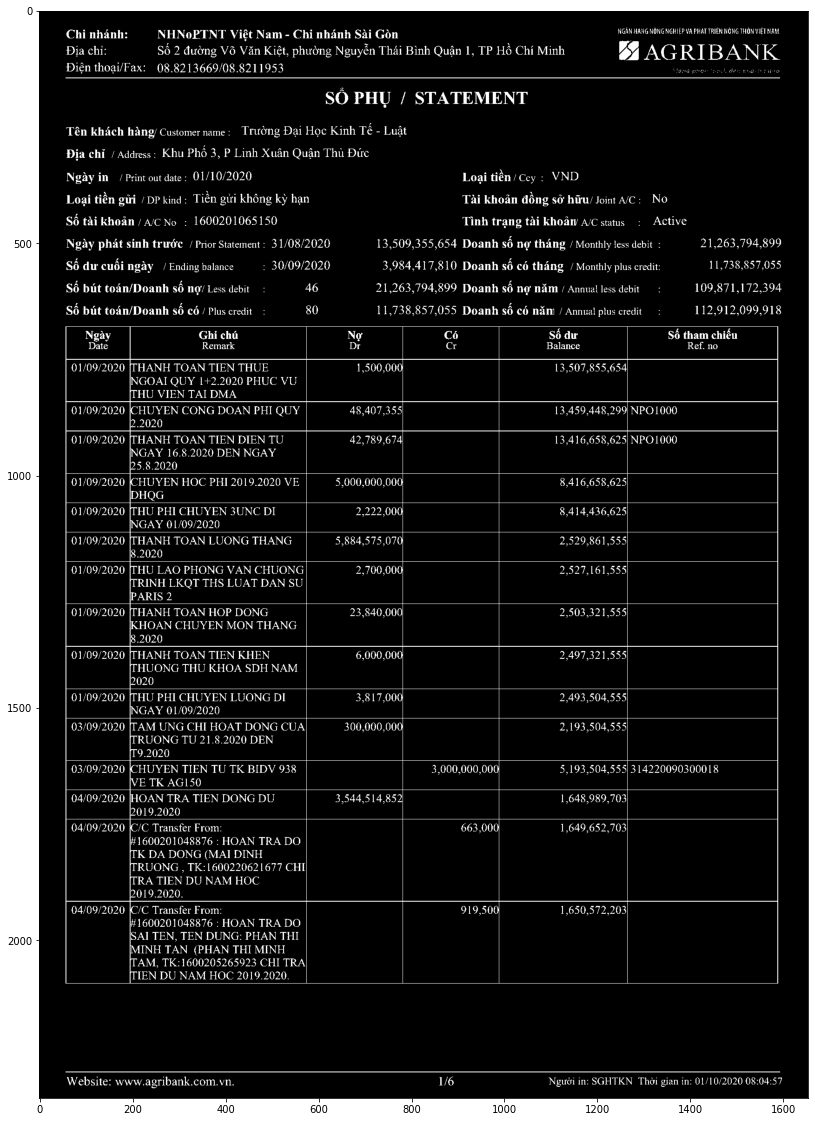

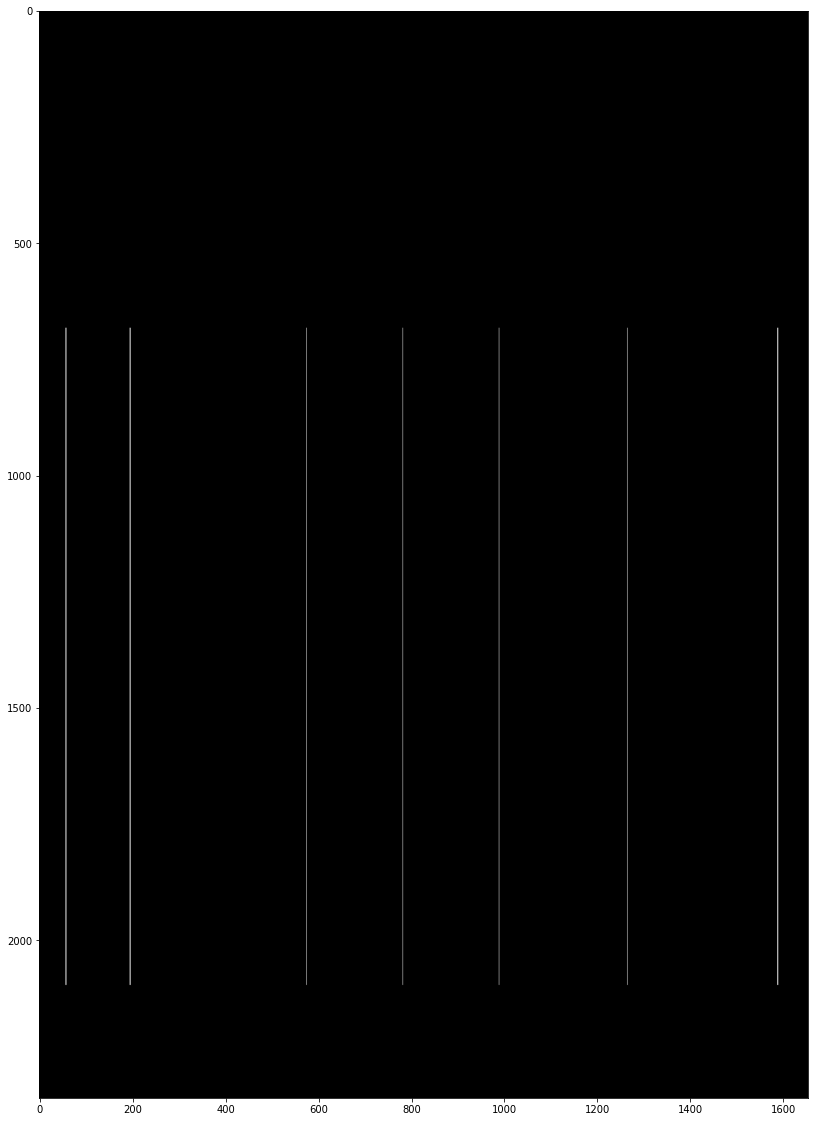

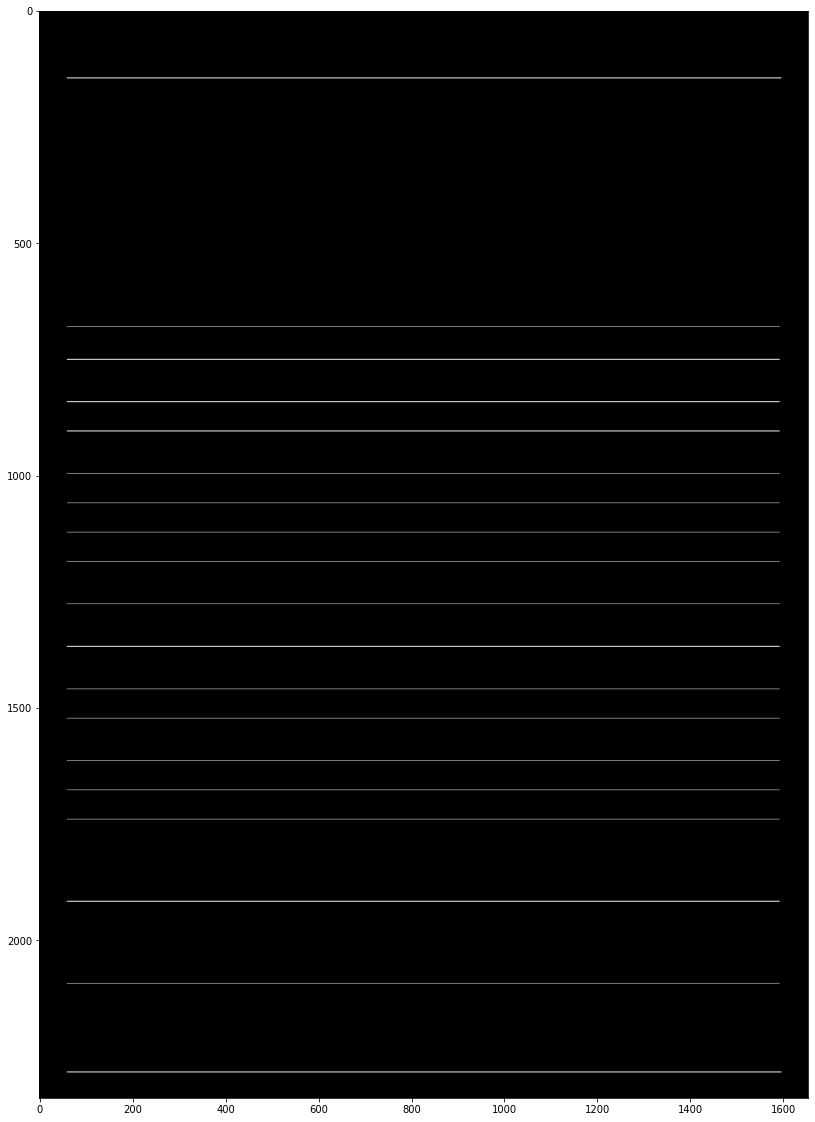

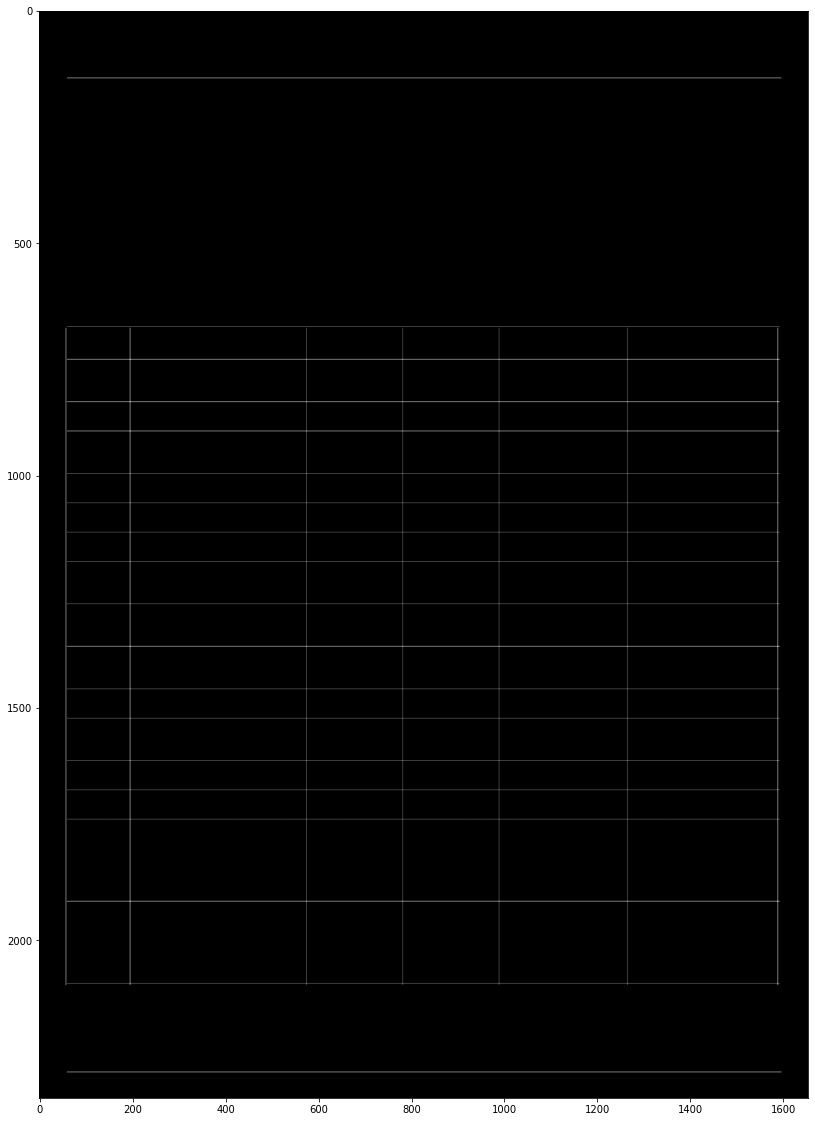

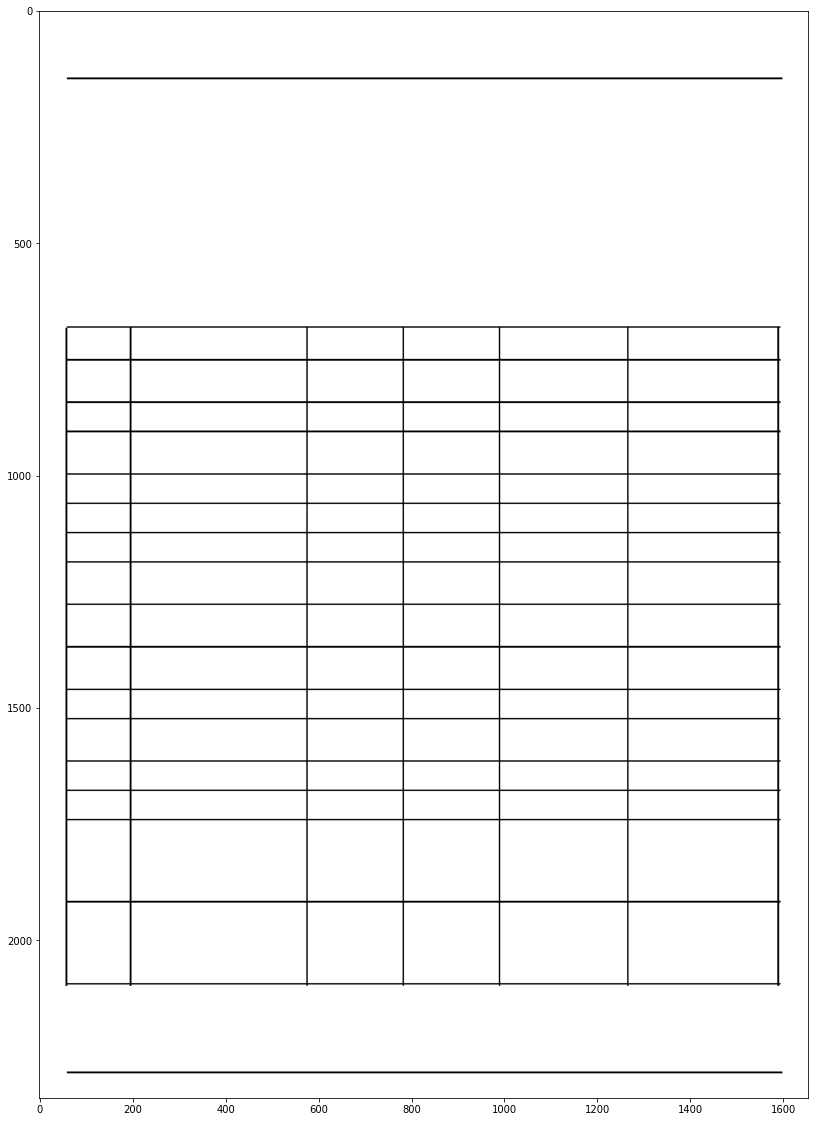

<Figure size 1440x1440 with 0 Axes>

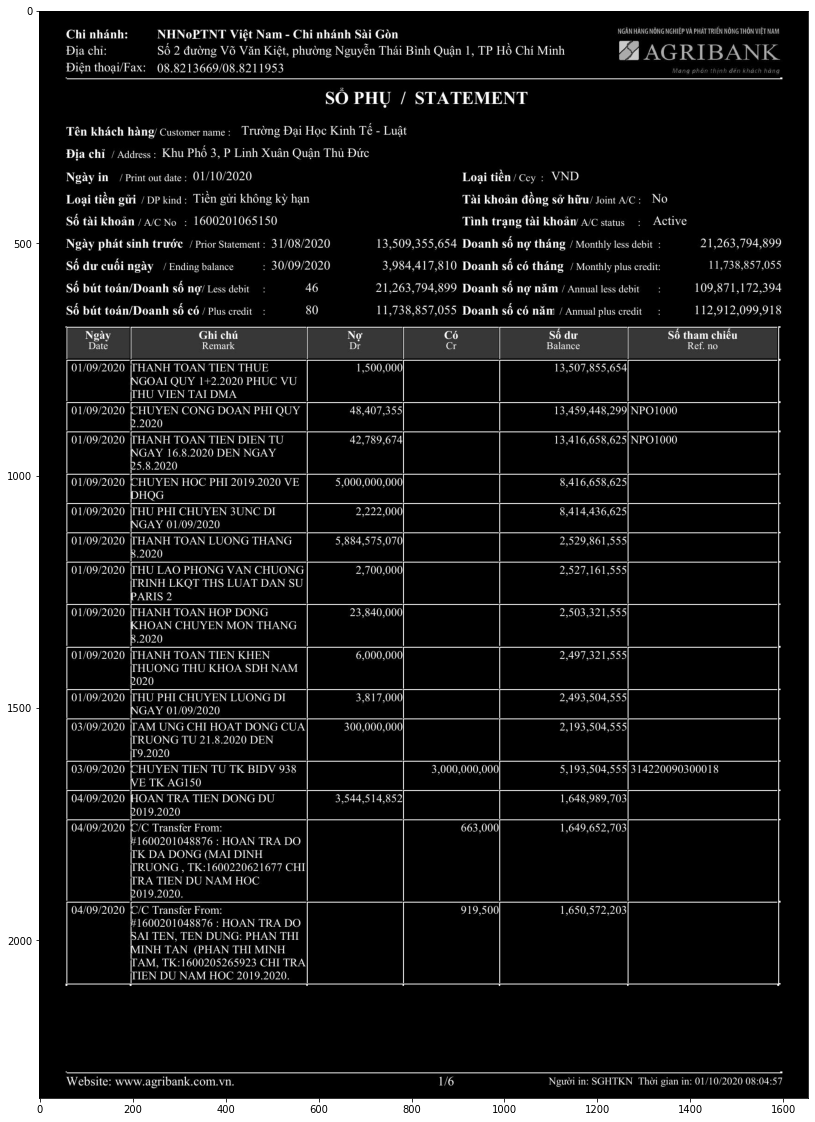

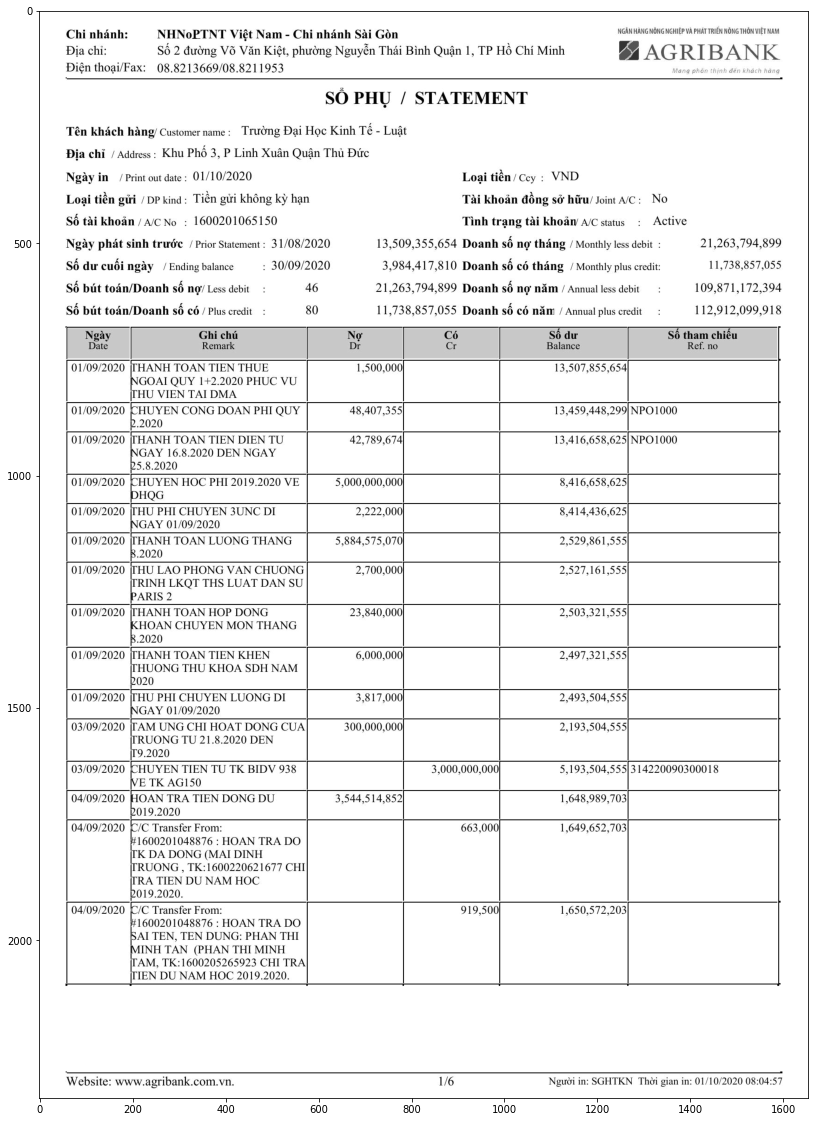

mean 119.25
[[1268, 683, 320, 67], [992, 683, 273, 67], [785, 683, 204, 67], [578, 683, 204, 67], [199, 683, 376, 67], [61, 683, 134, 67], [1268, 754, 320, 87], [992, 754, 273, 87], [785, 754, 204, 87], [578, 754, 204, 87], [199, 754, 376, 87], [61, 754, 134, 87], [1268, 845, 320, 59], [992, 845, 273, 59], [785, 845, 204, 59], [578, 845, 204, 59], [199, 845, 376, 59], [61, 845, 134, 59], [1268, 908, 320, 88], [992, 908, 273, 88], [785, 908, 204, 88], [578, 908, 204, 88], [199, 908, 376, 88], [61, 908, 134, 88], [1268, 999, 320, 60], [992, 999, 273, 60], [785, 999, 204, 60], [578, 999, 204, 60], [199, 999, 376, 60], [61, 999, 134, 60], [1268, 1062, 320, 60], [992, 1062, 273, 60], [785, 1062, 204, 60], [578, 1062, 204, 60], [199, 1062, 376, 60], [61, 1062, 134, 60], [1268, 1125, 320, 60], [992, 1125, 273, 60], [785, 1125, 204, 60], [578, 1125, 204, 60], [199, 1125, 376, 60], [61, 1125, 134, 60], [1268, 1188, 320, 88], [992, 1188, 273, 88], [785, 1188, 204, 88], [578, 1188, 204, 88], [199

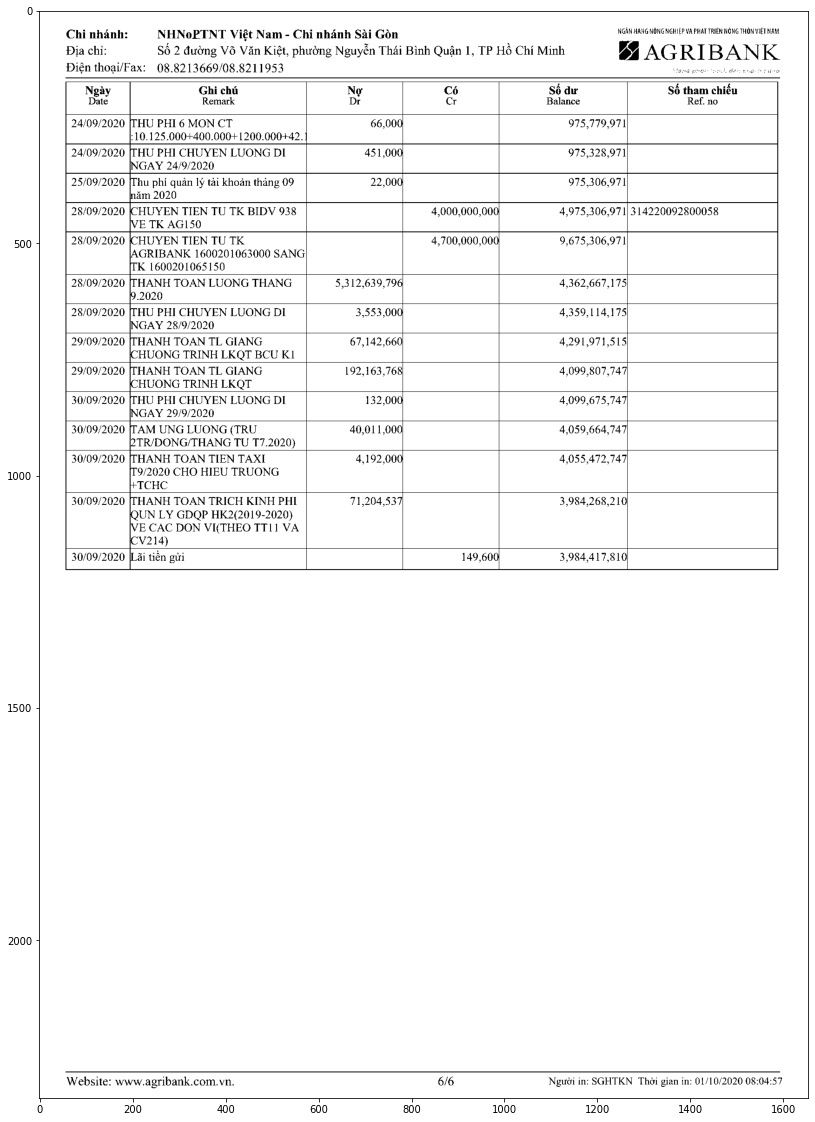

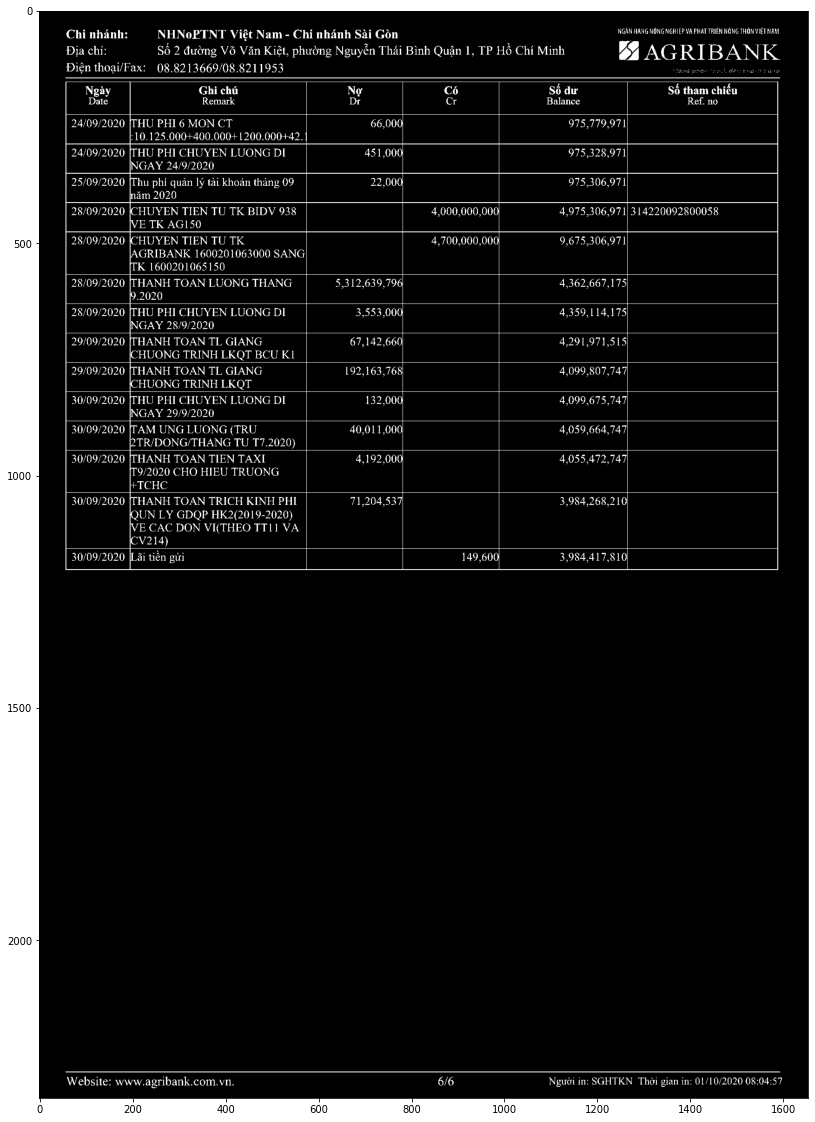

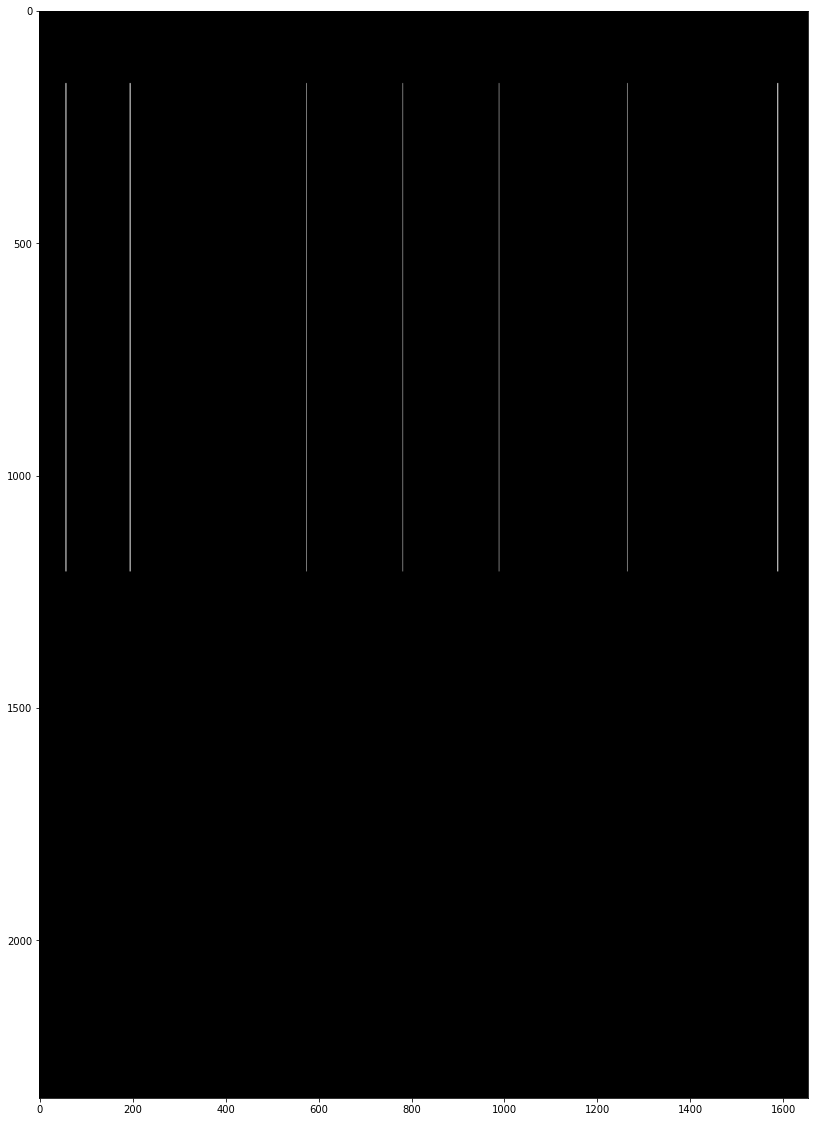

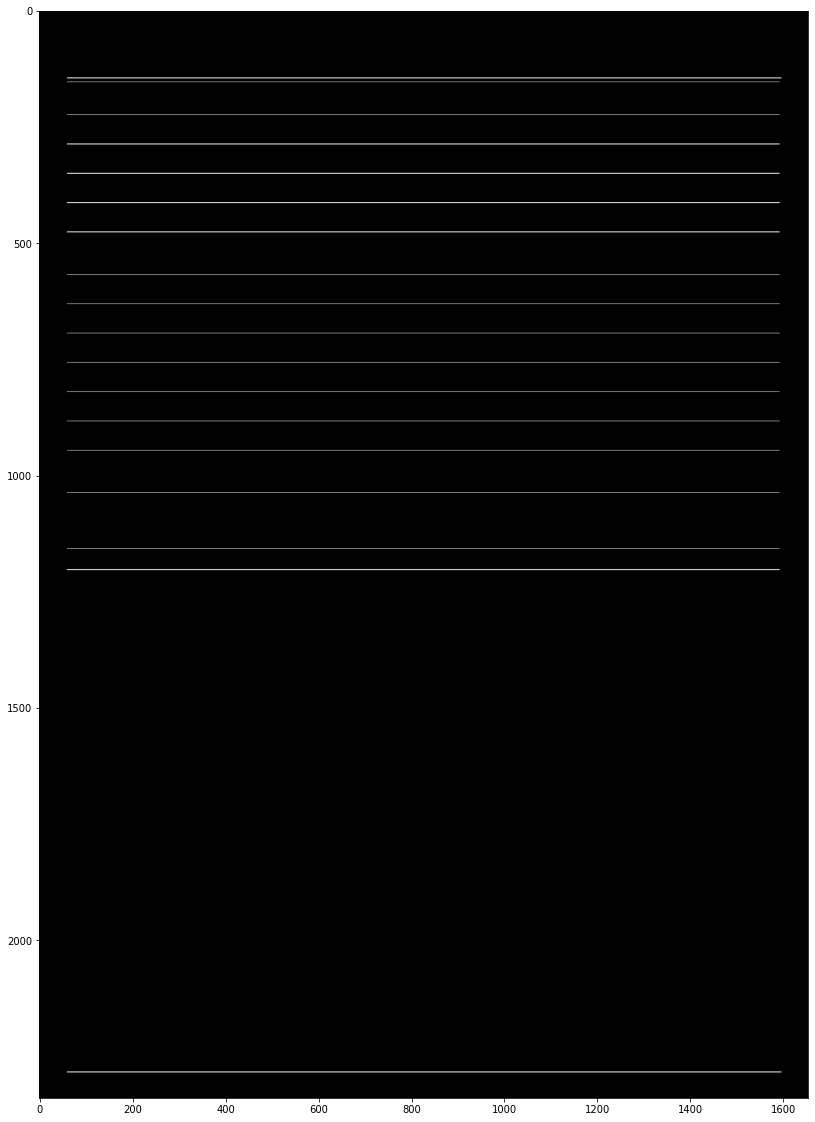

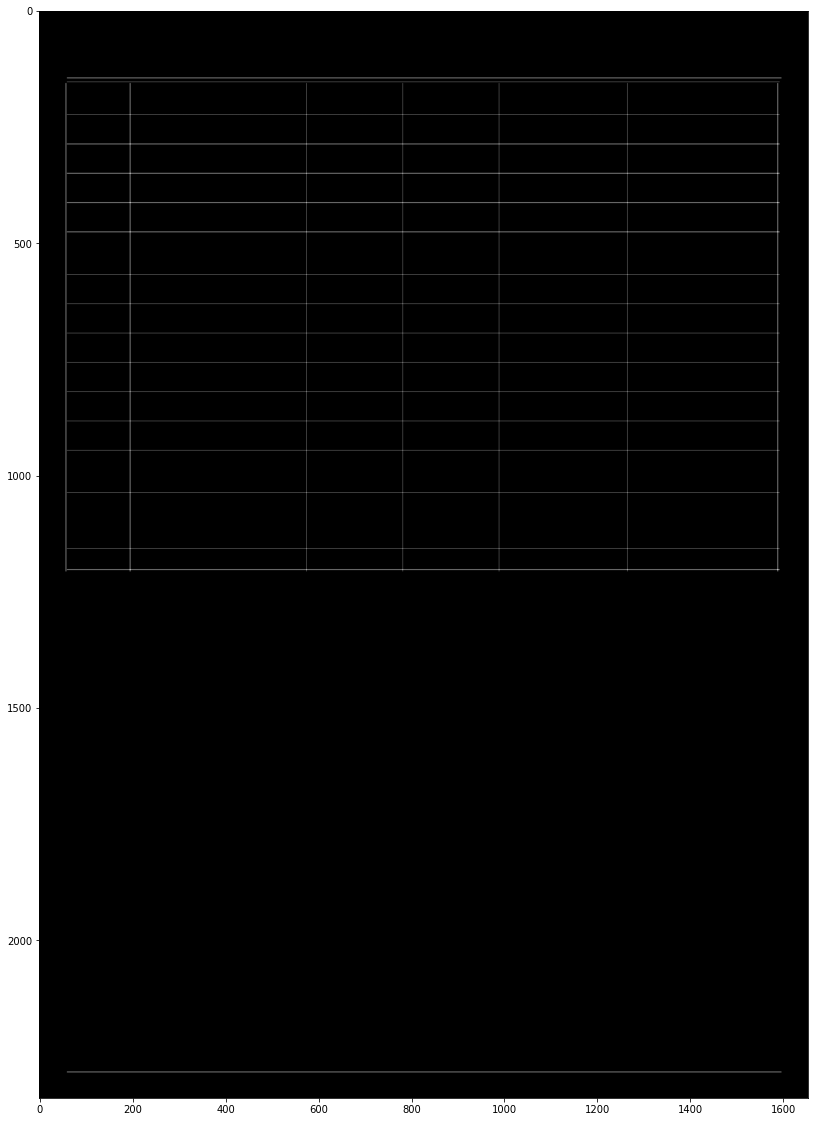

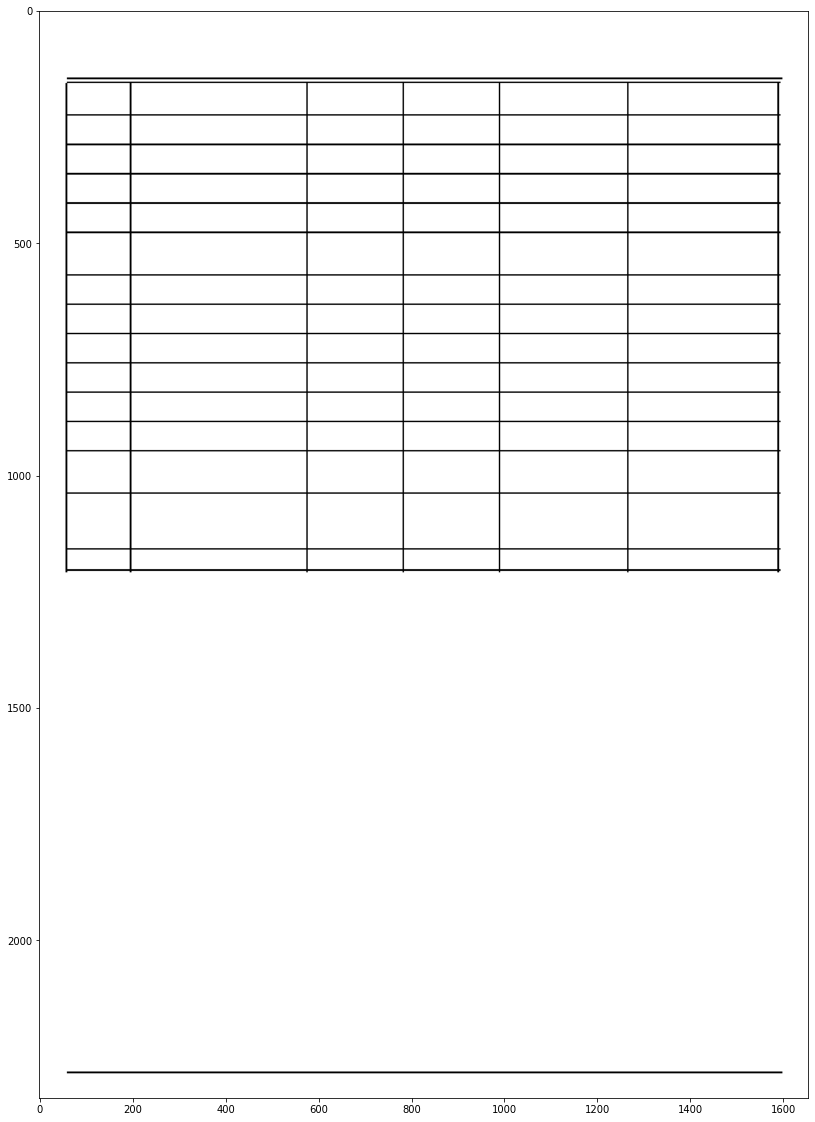

<Figure size 1440x1440 with 0 Axes>

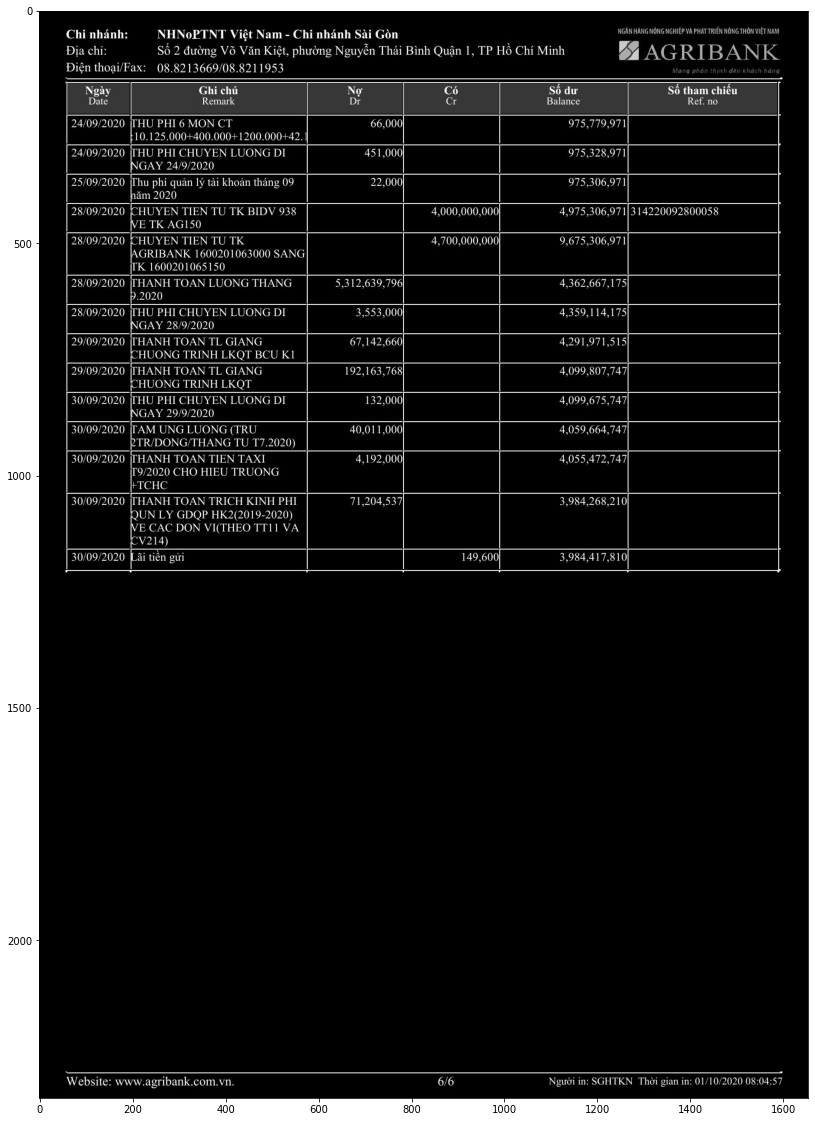

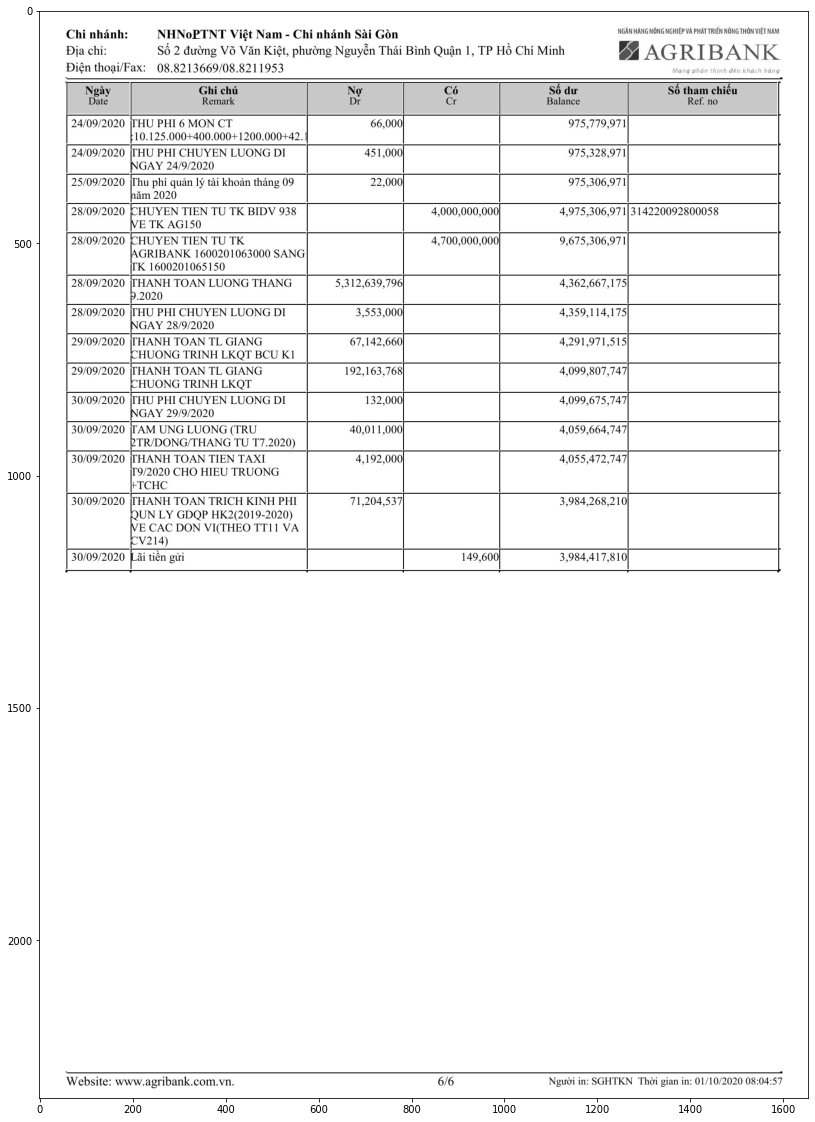

mean 100.02127659574468
[[1268, 157, 320, 67], [992, 157, 273, 67], [785, 157, 204, 67], [578, 157, 204, 67], [199, 157, 376, 67], [61, 157, 134, 67], [1268, 227, 320, 60], [992, 227, 273, 60], [785, 227, 204, 60], [578, 227, 204, 60], [199, 227, 376, 60], [61, 227, 134, 60], [1268, 291, 320, 59], [992, 291, 273, 59], [785, 291, 204, 59], [578, 291, 204, 59], [199, 291, 376, 59], [61, 291, 134, 59], [1268, 354, 320, 59], [992, 354, 273, 59], [785, 354, 204, 59], [578, 354, 204, 59], [199, 354, 376, 59], [61, 354, 134, 59], [1268, 417, 320, 59], [992, 417, 273, 59], [785, 417, 204, 59], [578, 417, 204, 59], [199, 417, 376, 59], [61, 417, 134, 59], [1268, 480, 320, 88], [992, 480, 273, 88], [785, 480, 204, 88], [578, 480, 204, 88], [199, 480, 376, 88], [61, 480, 134, 88], [1268, 571, 320, 60], [992, 571, 273, 60], [785, 571, 204, 60], [578, 571, 204, 60], [199, 571, 376, 60], [61, 571, 134, 60], [1268, 634, 320, 60], [992, 634, 273, 60], [785, 634, 204, 60], [578, 634, 204, 60], [199, 63

In [5]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
from pdf2image import convert_from_path

import glob
import os
import shutil

def pdf_to_img(dir, filepath):
    # Get file name
    # fname = os.path.split(filepath)[1]

    # Create a temp folder to store extracted images
    temp = dir[0] + '/temp'
    if not os.path.exists(temp): 
        os.mkdir(temp)  
    else:
        remove_temp_folder(dir)
        os.mkdir(temp)
    # except OSError as e:
    #     print("Error: %s" % (e.strerror))

    # Convert PDF pages into images            
    images = convert_from_path(filepath)
    for i in range(len(images)):
        images[i].save(dir[0] + '/' + 'temp/' + dir[1].split('.')[0] + '_' + str(i+1).zfill(4) +'.jpg', 'JPEG')
    
    return glob.glob(dir[0] + '/' + 'temp/*.jpg')

def remove_temp_folder(dir):
    temp = dir[0] + '/temp'
    try:
        shutil.rmtree(temp)
    except OSError as e:
        print("Error : %s" % (e.strerror))

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

def detect_lines(img):
    #thresholding the image to a binary image
    thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY |cv2.THRESH_OTSU)
    plt.figure(figsize=(20,20))
    plt.imshow(img_bin, cmap='gray')
    plt.show()
    #inverting the image 
    img_bin = 255-img_bin
    plt.figure(figsize=(20,20))
    plt.imshow(img_bin, cmap='gray')
    plt.show()
    # Length(width) of kernel as 100th of total width
    kernel_len = np.array(img).shape[1]//100
    # Defining a vertical kernel to detect all vertical lines of image 
    ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
    # Defining a horizontal kernel to detect all horizontal lines of image
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
    # A kernel of 2x2
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    #Use vertical kernel to detect and save the vertical lines in a jpg
    image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
    vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
    #Use horizontal kernel to detect and save the horizontal lines in a jpg
    image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
    horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
    # Combine horizontal and vertical lines in a new third image, with both having same weight.
    img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
    plt.figure(figsize=(20,20))
    plt.imshow(vertical_lines, cmap='gray')
    plt.show()    
    plt.figure(figsize=(20,20))
    plt.imshow(horizontal_lines, cmap='gray')
    plt.show()    
    plt.figure(figsize=(20,20))
    plt.imshow(img_vh, cmap='gray')
    plt.show()    
    #Eroding and thesholding the image
    img_vh = cv2.erode(~img_vh, kernel, iterations=2)
    thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    bitxor = cv2.bitwise_xor(img,img_vh)
    bitnot = cv2.bitwise_not(bitxor)
    plt.figure(figsize=(20,20))
    plt.imshow(img_vh, cmap='gray')
    plt.figure(figsize=(20,20))
    plt.show()    
    plt.figure(figsize=(20,20))
    plt.imshow(bitxor, cmap='gray')
    plt.show()    
    plt.figure(figsize=(20,20))
    plt.imshow(bitnot, cmap='gray')
    plt.show()   
    # Detect contours for following box detection
    contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  
    # Sort all the contours by top to bottom.
    contours, boundingBoxes = sort_contours(contours, method='top-to-bottom')
    return bitnot, contours, boundingBoxes

def get_cells(img, contours, boundingBoxes):
    #Creating a list of heights for all detected boxes
    heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]
    #Get mean of heights
    mean = np.mean(heights)
    print('mean', mean)
    #Create list box to store all boxes in  
    box = []
    # Get position (x,y), width and height for every contour and show the contour on image
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if (w<1000 and h<500):
            image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            box.append([x,y,w,h])
    print(box)
    #Creating two lists to define row and column in which cell is located
    row=[]
    column=[]
    j=0
    #Sorting the boxes to their respective row and column
    for i in range(len(box)):
        if(i==0):
            column.append(box[i])
            previous=box[i]
        else:
            if(box[i][1]<=previous[1]+mean/8):
                column.append(box[i])
                previous=box[i]
                if(i==len(box)-1):
                    row.append(column)
            else:
                row.append(column)
                column=[]
                previous = box[i]
                column.append(box[i])
    print('column', column, '\nrow', row)
    #calculating maximum number of cells
    countcol = 0
    for i in range(len(row)):
        countcol = len(row[i])
        if countcol > countcol:
            countcol = countcol
    print(countcol)
    #Retrieving the center of each column
    center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]
    center=np.array(center)
    center.sort()
    print('center', center)
    #Regarding the distance to the columns center, the boxes are arranged in respective order
    finalboxes = []
    for i in range(len(row)):
        lis=[]
        for k in range(countcol):
            lis.append([])
        for j in range(len(row[i])):
            diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
            minimum = min(diff)
            indexing = list(diff).index(minimum)
            lis[indexing].append(row[i][j])
        finalboxes.append(lis)
    print('finalboxes', finalboxes)
    return row, countcol, finalboxes

def extract_text(dir, imgpath, bitnot, row, countcol, finalboxes):
    #from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
    outer=[]
    # i stands for row position, j stands for column position
    for i in range(len(finalboxes)):
        for j in range(len(finalboxes[i])):
            print(f'finalbox[{i}][{j}] == {finalboxes[i][j]}')
            inner=''
            if(len(finalboxes[i][j])==0):
                outer.append(' ')
            else:
                for k in range(len(finalboxes[i][j])):
                    y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                    finalimg = bitnot[x:x+h, y:y+w]
                    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                    border = cv2.copyMakeBorder(finalimg,2,2,2,2,   cv2.BORDER_CONSTANT,value=[255,255])
                    resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                    dilation = cv2.dilate(resizing, kernel,iterations=1)
                    erosion = cv2.erode(dilation, kernel,iterations=1)

                    if i==0: #first row: table title 
                        out = pytesseract.image_to_string(erosion, config='-l vie')
                    else:
                        if j==0: #first col: date time
                            out = pytesseract.image_to_string(erosion, config='-l eng --psm 12')
                        elif j==2 or j==3 or j==4:
                            out = pytesseract.image_to_string(erosion, config='-l eng -c tessedit_char_whitelist=0123456789,')
                        elif j==5: 
                            out = pytesseract.image_to_string(erosion, config='-l eng -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789')
                        else:
                            out = pytesseract.image_to_string(erosion)
#                     print(out)
                    if(len(out)==0):
                        out = pytesseract.image_to_string(erosion, config='--psm 3')
                    print(out)
                    inner = inner +" "+ out.replace('\x0c', '')
                    
                outer.append(inner)
            
    #Creating a dataframe of the generated OCR list
    arr = np.array(outer)
    dataframe = pd.DataFrame(arr.reshape(len(row),countcol))
    # print(dataframe)
    data = dataframe.style.set_properties(align="left")
    filename = dir[0] + '/' + dir[1].split('.')[0] + '_output.xlsx'
    sheetname = os.path.split(imgpath)[1].split('.')[0].split('_')[1]
    #Converting it in a excel-file
#     if os.path.exists(filename):
#         with pd.ExcelWriter(filename, mode='a') as writer:  
#             data.to_excel(writer, encoding = 'utf-8', sheet_name = sheetname)
#     else:
#         with pd.ExcelWriter(filename, mode='w') as writer:  
#             data.to_excel(writer, encoding = 'utf-8', sheet_name = sheetname) # , index = False
  
############### MAIN ###############
def main_convert(lspaths):    


    for pdffile in lspaths:
        dir = os.path.split(pdffile)
#         print(dir)
        images = pdf_to_img(dir, pdffile)
        
        for imgpath in sorted(images):
            #read your file
            img = cv2.imread(imgpath,0)
            bitnot, contours, boundingBoxes = detect_lines(img)
            row, countcol, finalboxes       = get_cells(img, contours, boundingBoxes)
            outer                           = extract_text(dir, imgpath, bitnot, row, countcol, finalboxes)



        remove_temp_folder(dir)

if __name__== "__main__":
    path = glob.glob('/home/anvnt/Documents/PDF-SaoKeNH/*.pdf')
    main_convert(path)
